# CISA KVE EPSS Data Analyis 

In [1]:
import pandas as pd
import json
import requests
import os
import glob
import numpy as np

In [2]:
cisa_df = pd.read_csv("https://www.cisa.gov/sites/default/files/csv/known_exploited_vulnerabilities.csv")
cisa_df = cisa_df
cisa_df.columns = cisa_df.columns.str.strip("\u200b")
cisa_df = cisa_df.rename(columns={"cveID": "CVE", "shortDescription" : "Description", "vendorProject" : "Vendor", "product" : "Product"})

In [3]:
epss = pd.read_csv('epss_scores-current.csv', skiprows=1)
epss = epss.rename(columns={"cve": "CVE", "epss" : "EPSS", "percentile" : "EPSS Percentile"})

In [4]:
row_accumulator = []
for filename in glob.glob('nvdcve-2.0-*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['vulnerabilities']:
            cve = entry['cve']['id']
            base_score = 0.0
            metrics = entry['cve'].get('metrics', {})
            cvss_v31 = metrics.get('cvssMetricV31', [{}])
            if cvss_v31 and 'cvssData' in cvss_v31[0]:
                base_score = cvss_v31[0]['cvssData'].get('baseScore', 0.0)
            new_row = {
                'CVE': cve,
                'CVSS3': base_score,
            }
            row_accumulator.append(new_row)

# Create DataFrame after all files are processed
nvd = pd.DataFrame(row_accumulator)
nvd['CVSS3'] = pd.to_numeric(nvd['CVSS3'])
nvd['CVSS3'] = nvd['CVSS3'].replace(0, np.nan)

In [5]:
epss_kev = pd.merge(cisa_df, epss, left_on='CVE', right_on='CVE')
epss_kev_nvd =  pd.merge(epss_kev, nvd, left_on='CVE', right_on='CVE')
epss_kev_nvd =  epss_kev_nvd[["CVE", "CVSS3", "EPSS", "EPSS Percentile", "Description", "Vendor", "Product"]]

In [6]:
epss_kev_nvd

,CVE,CVSS3,EPSS,EPSS Percentile,Description,Vendor,Product
0,CVE-2025-6218,NaN,0.08030,0.91785,RARLAB WinRAR contains a path traversal vulner...,RARLAB,WinRAR
1,CVE-2025-62221,7.8,0.08212,0.91885,Microsoft Windows Cloud Files Mini Filter Driv...,Microsoft,Windows
2,CVE-2022-37055,9.8,0.73907,0.98763,D-Link Routers contains a buffer overflow vuln...,D-Link,Routers
3,CVE-2025-66644,7.2,0.02244,0.84074,Array Networks ArrayOS AG contains an OS comma...,Array Networks,ArrayOS AG
4,CVE-2025-55182,10.0,0.77804,0.98948,Meta React Server Components contains a remote...,Meta,React Server Components
...,...,...,...,...,...,...,...
1467,CVE-2021-27561,9.8,0.94106,0.99901,Yealink Device Management contains a server-si...,Yealink,Device Management
1468,CVE-2021-40539,9.8,0.94424,0.99980,Zoho ManageEngine ADSelfService Plus contains ...,Zoho,ManageEngine
1469,CVE-2020-10189,9.8,0.94248,0.99923,Zoho ManageEngine Desktop Central contains a f...,Zoho,ManageEngine
1470,CVE-2019-8394,6.5,0.87213,0.99412,Zoho ManageEngine ServiceDesk Plus (SDP) conta...,Zoho,ManageEngine


## CISA KEV Score Scatter Plot

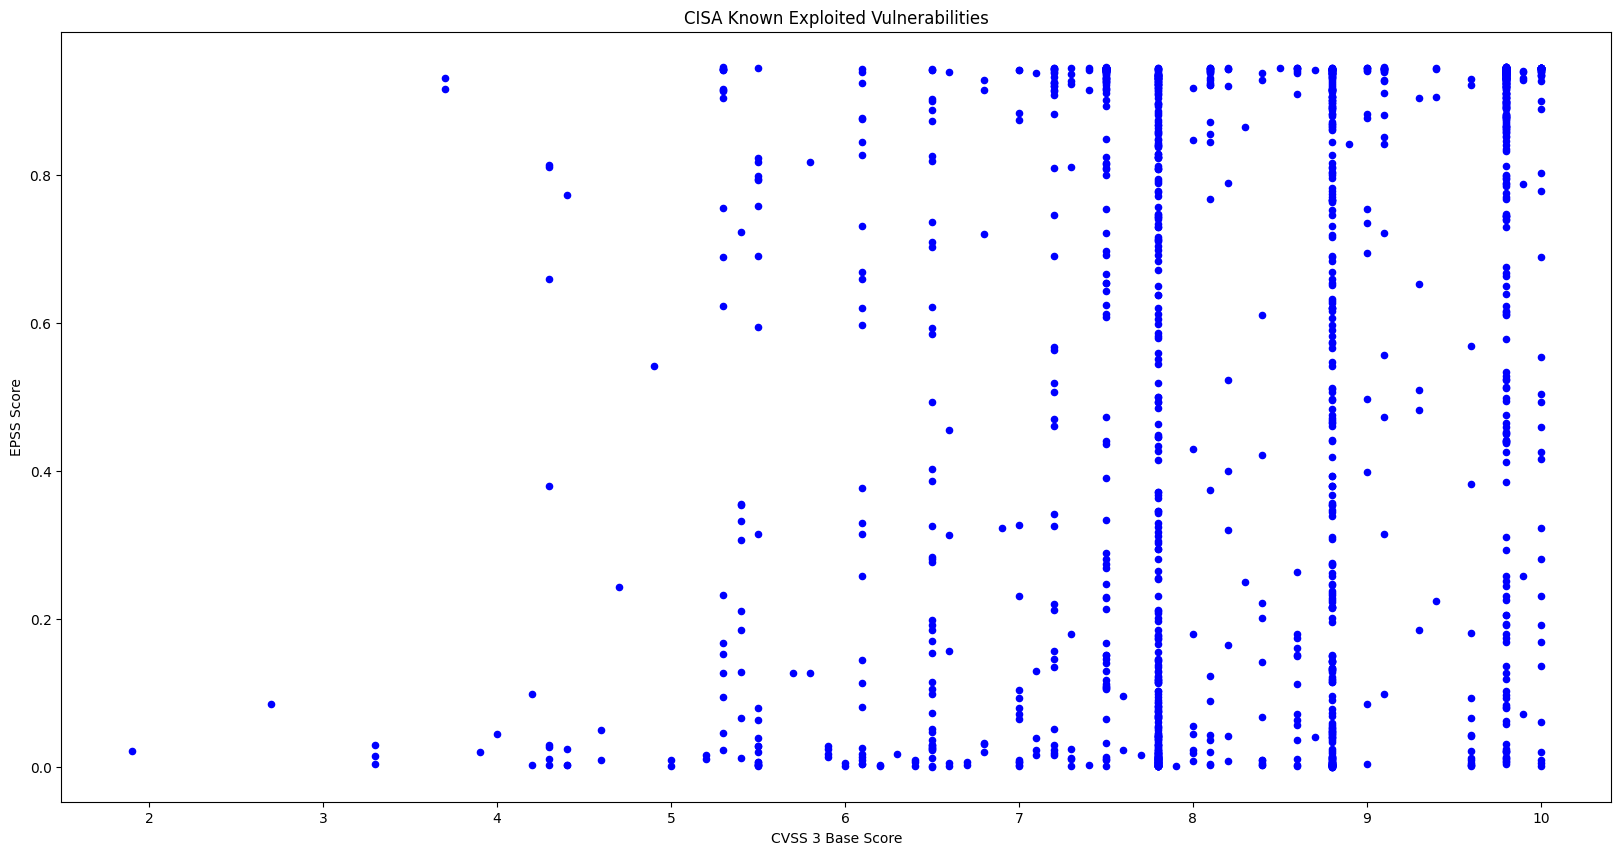

In [7]:
ax = epss_kev_nvd.plot.scatter(x='CVSS3',
                                 y='EPSS',
                                 figsize=(20, 10),
                                 title='CISA Known Exploited Vulnerabilities',
                                 color='blue')
ax.set_xlabel("CVSS 3 Base Score")
ax.set_ylabel("EPSS Score")
ax.get_figure().savefig('epss_kev_nvd.png')

## Export to CVS

In [8]:
epss_kev_nvd.to_csv("epss_kev_nvd.csv", index=False)
epss_kev_nvd.head(10)

,CVE,CVSS3,EPSS,EPSS Percentile,Description,Vendor,Product
0,CVE-2025-6218,NaN,0.08030,0.91785,RARLAB WinRAR contains a path traversal vulner...,RARLAB,WinRAR
1,CVE-2025-62221,7.8,0.08212,0.91885,Microsoft Windows Cloud Files Mini Filter Driv...,Microsoft,Windows
2,CVE-2022-37055,9.8,0.73907,0.98763,D-Link Routers contains a buffer overflow vuln...,D-Link,Routers
3,CVE-2025-66644,7.2,0.02244,0.84074,Array Networks ArrayOS AG contains an OS comma...,Array Networks,ArrayOS AG
4,CVE-2025-55182,10.0,0.77804,0.98948,Meta React Server Components contains a remote...,Meta,React Server Components
5,CVE-2021-26828,8.8,0.81551,0.99135,OpenPLC ScadaBR contains an unrestricted uploa...,OpenPLC,ScadaBR
6,CVE-2025-48633,5.5,0.00355,0.57179,Android Framework contains an unspecified vuln...,Android,Framework
7,CVE-2025-48572,7.8,0.00595,0.68533,Android Framework contains an unspecified vuln...,Android,Framework
8,CVE-2021-26829,5.4,0.35401,0.96877,OpenPLC ScadaBR contains a cross-site scriptin...,OpenPLC,ScadaBR
9,CVE-2025-61757,9.8,0.79446,0.99029,Oracle Fusion Middleware contains a missing au...,Oracle,Fusion Middleware
